In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "5,6,7,8,9"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch, torch.cuda as c
print("Torch:", torch.__version__)
print("Compiled CUDA:", torch.version.cuda)
print("CUDA available:", c.is_available())
if c.is_available():
    print("Arch list:", c.get_arch_list())
    print("Device:", c.get_device_name(0))

Torch: 2.9.1+cu126
Compiled CUDA: 12.6
CUDA available: True
Arch list: ['sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90']
Device: NVIDIA TITAN Xp


In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "5,6,7,8,9"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.env_util import make_vec_env

gym.register_envs(ale_py)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
vec_env = make_vec_env("ALE/DonkeyKong-v5", n_envs=1, monitor_dir="./logs/")
print(vec_env.observation_space)
print(vec_env.action_space)

Box(0, 255, (210, 160, 3), uint8)
Discrete(18)


In [6]:
model = DQN(
    policy="CnnPolicy", # built-in CNN for images
    env=vec_env,
    verbose=1,
    buffer_size=100_000, # replay buffer size
    learning_rate=1e-4,
    batch_size=32,
    train_freq=4, # update the network every 4 steps
    target_update_interval=10_000, # update the target network every 10000 steps
	device=device
)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [7]:
model.learn(total_timesteps=10_000, progress_bar=True)
model.save("dqn_donkeykong")

Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 679      |
|    ep_rew_mean      | 100      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 155      |
|    time_elapsed     | 17       |
|    total_timesteps  | 2715     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000166 |
|    n_updates        | 653      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 690      |
|    ep_rew_mean      | 75       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 152      |
|    time_elapsed     | 36       |
|    total_timesteps  | 5524     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 9.6e-05  |
|    n_updates        | 1355     |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 701      |
|    ep_rew_mean      | 83.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 151      |
|    time_elapsed     | 55       |
|    total_timesteps  | 8411     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 5.06e-05 |
|    n_updates        | 2077     |
----------------------------------


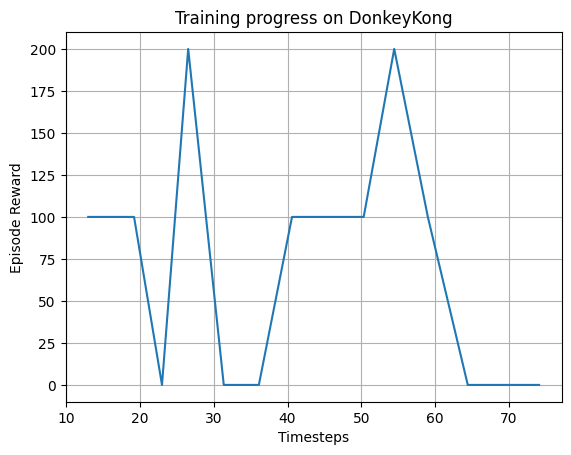

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

log_files = glob.glob("./logs/*.monitor.csv")
dfs = []
for f in log_files:
    # SB3 Monitor files start with header comments, skip them
    df = pd.read_csv(f, skiprows=1)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# df has columns: r (reward), l (length), t (time), etc.
plt.plot(df["t"], df["r"])
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward")
plt.title("Training progress on DonkeyKong")
plt.grid(True)
plt.show()

In [17]:
import gymnasium as gym
import ale_py
import imageio
from stable_baselines3 import DQN

# Make sure ALE envs are registered
gym.register_envs(ale_py)

# Load trained model (no env needed here)
model = DQN.load("dqn_donkeykong")

# Fresh env ONLY for recording
env = gym.make("ALE/DonkeyKong-v5", render_mode="rgb_array")

frames = []
obs, info = env.reset()
terminated = False
truncated = False

# Optional: take some random actions to get past static start screen
for _ in range(10):
    # NOOP is often 0, but you can use random actions if you want
    obs, _, terminated, truncated, info = env.step(env.action_space.sample())
    if terminated or truncated:
        obs, info = env.reset()

# Now let the trained agent play
for step in range(2000):
    # Get the **current** frame AFTER the environment has progressed
    frame = env.render()            # (H, W, 3) RGB numpy array
    frames.append(frame)

    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        break

env.close()

# Save as GIF
imageio.mimsave("donkeykong_agent.gif", frames, fps=30)
